In [ ]:
import time
from dataclasses import dataclass
from typing import Dict, Any

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from src.models.base import ModelConfig
from src.models.rnn import ElmanRNN, LSTM, UnitaryRNN
from src.models.lru import LinearRecurrentUnit
from src.data.copy_dataset import CopyDataset


In [ ]:
config = {
    "model_name": "lstm",  # options: elman, lstm, lru, unitary
    "hidden_dim": 64,
    "use_layer_norm": False,
    "nonlinearity": "relu",
    "train_steps": 200,
    "learning_rate": 1e-3,
    "batch_size": 32,
    "min_lag": 10,
    "max_lag": 15,
    "num_classes": 10,
    "seq_length": 10,
    "precision": "float32",
}
config


{'model_name': 'lstm',
 'hidden_dim': 64,
 'use_layer_norm': False,
 'nonlinearity': 'relu',
 'train_steps': 200,
 'learning_rate': 0.001,
 'batch_size': 32,
 'min_lag': 10,
 'max_lag': 15,
 'num_classes': 10,
 'seq_length': 10,
 'precision': 'float32'}

In [ ]:
MODEL_REGISTRY = {
    "elman": lambda cfg: ElmanRNN(cfg, nonlinearity=config["nonlinearity"]),
    "lstm": lambda cfg: LSTM(cfg),
    "lru": lambda cfg: LinearRecurrentUnit(cfg, mlp_hidden_dim=cfg.hidden_dim),
    "unitary": lambda cfg: UnitaryRNN(cfg, nonlinearity=config["nonlinearity"]),
}

def build_model_from_config(cfg: Dict[str, Any]):
    model_cfg = ModelConfig(
        input_dim=cfg["num_classes"],
        output_dim=cfg["num_classes"],
        hidden_dim=cfg["hidden_dim"],
        precision=cfg["precision"],
        param_dtype=cfg["precision"],
        use_layer_norm=cfg.get("use_layer_norm", False),
    )
    model_fn = MODEL_REGISTRY[cfg["model_name"].lower()]
    return model_fn(model_cfg), model_cfg


@dataclass
class TrainState:
    params: Any
    opt_state: Any


def embed_inputs(token_ids, num_classes, precision):
    embedded = jax.nn.one_hot(token_ids, num_classes, dtype=jnp.float32)
    if precision == "bfloat16":
        embedded = embedded.astype(jnp.bfloat16)
    return embedded


In [ ]:
from tqdm import tqdm 
def run_training(cfg):
    dataset = CopyDataset(
        min_lag=cfg["min_lag"],
        max_lag=cfg["max_lag"],
        batch_size=cfg["batch_size"],
        num_classes=cfg["num_classes"],
        seq_length=cfg["seq_length"],
    )
    model, model_cfg = build_model_from_config(cfg)
    params = model.initialize(jax.random.PRNGKey(0))
    optimizer = optax.adam(cfg["learning_rate"])
    opt_state = optimizer.init(params)

    def loss_fn(p, batch):
        inputs, targets, mask = batch
        embedded = embed_inputs(inputs, cfg["num_classes"], cfg["precision"])
        logits = model.apply(p, embedded, mask)
        log_probs = jax.nn.log_softmax(logits, axis=-1)
        nll = -jnp.sum(jnp.take_along_axis(log_probs, targets[..., None], axis=-1)[..., 0] * mask) / jnp.sum(mask)
        accuracy = jnp.sum((jnp.argmax(logits, axis=-1) == targets) * mask) / jnp.sum(mask)
        return nll, {"nll": nll, "accuracy": accuracy}

   
    def train_step(state: TrainState, batch):
        (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, batch)
        updates, new_opt_state = optimizer.update(grads, state.opt_state, state.params)
        new_params = optax.apply_updates(state.params, updates)
        return TrainState(new_params, new_opt_state), metrics

    history = {"nll": [], "accuracy": []}
    state = TrainState(params, opt_state)
    for step in tqdm(range(1, cfg["train_steps"] + 1)):
        batch = dataset()
        inputs, targets, mask = batch
        mask = mask.astype(jnp.float32)
        state, metrics = train_step(state, (inputs, targets, mask))
        history["nll"].append(float(metrics["nll"]))
        history["accuracy"].append(float(metrics["accuracy"]))
        if step % max(1, cfg["train_steps"] // 10) == 0:
            print(f"Step {step}/{cfg['train_steps']} - nll {metrics['nll']:.4f} acc {metrics['accuracy']:.3f}")

    return state, history, dataset, model

state, history, dataset, model = run_training(config)


 10%|█         | 20/200 [00:08<01:10,  2.56it/s]

Step 20/200 - nll 2.1782 acc 0.103


 20%|██        | 40/200 [00:16<01:03,  2.51it/s]

Step 40/200 - nll 2.0910 acc 0.147


 30%|███       | 60/200 [00:24<00:56,  2.48it/s]

Step 60/200 - nll 2.0957 acc 0.125


 40%|████      | 80/200 [00:32<00:48,  2.48it/s]

Step 80/200 - nll 2.0866 acc 0.109


 50%|█████     | 100/200 [00:41<00:41,  2.43it/s]

Step 100/200 - nll 2.0869 acc 0.109


 60%|██████    | 120/200 [00:49<00:33,  2.39it/s]

Step 120/200 - nll 2.0827 acc 0.116


 70%|███████   | 140/200 [00:58<00:24,  2.48it/s]

Step 140/200 - nll 2.0849 acc 0.156


 80%|████████  | 160/200 [01:07<00:16,  2.36it/s]

Step 160/200 - nll 2.0723 acc 0.156


 90%|█████████ | 180/200 [01:15<00:08,  2.47it/s]

Step 180/200 - nll 2.0706 acc 0.156


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]

Step 200/200 - nll 2.0404 acc 0.147


In [ ]:
os.environ.setdefault("WANDB_MODE", "disabled")
train_copy(task_cfg, model_cfg, train_cfg, optimizer_cfg)



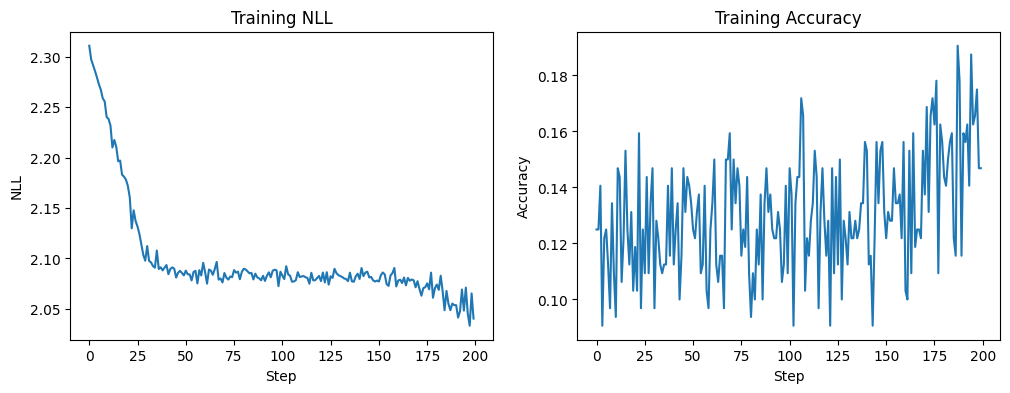

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history["nll"])
ax[0].set_title("Training NLL")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("NLL")
ax[1].plot(history["accuracy"])
ax[1].set_title("Training Accuracy")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Accuracy")
plt.show()


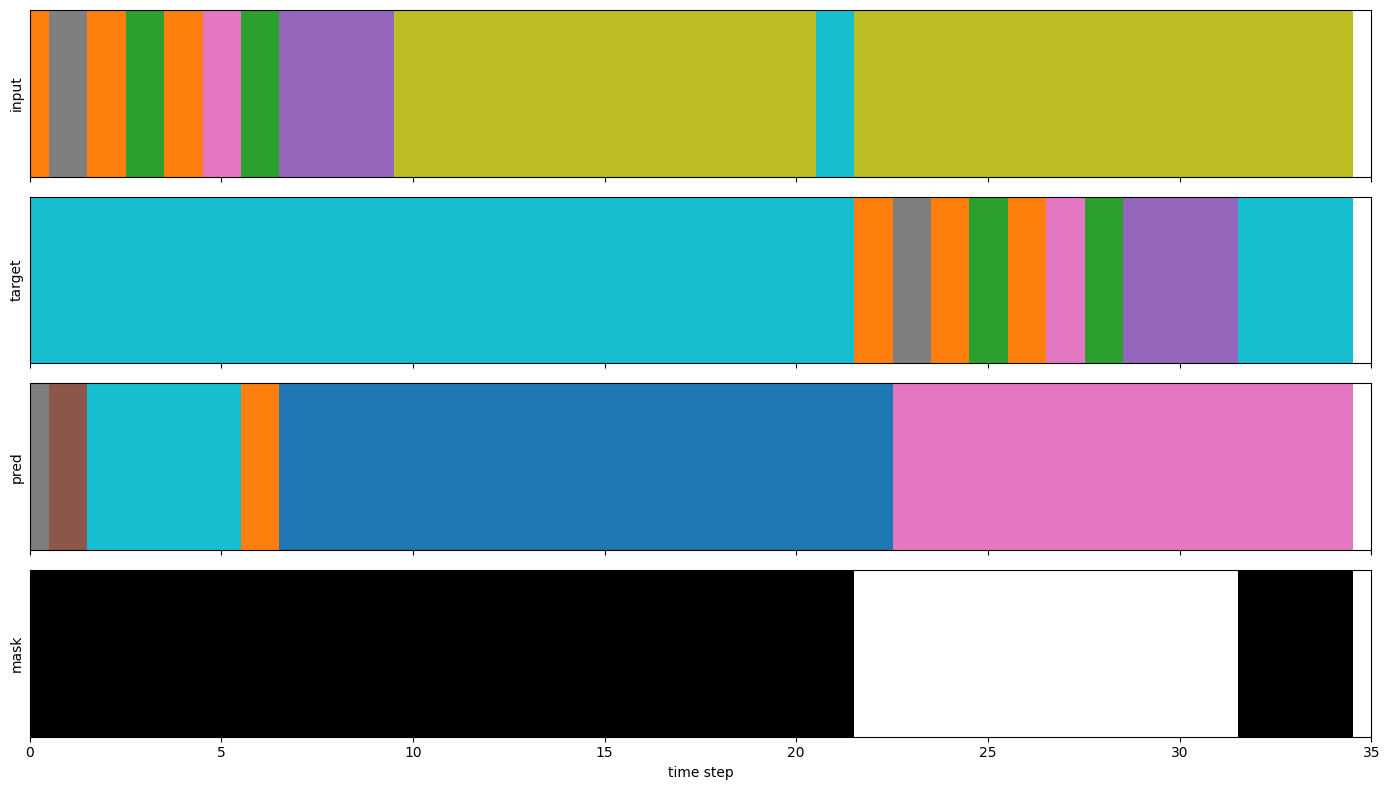

Sequence accuracy: 0.100


In [ ]:
def visualize_predictions(state, model, dataset, cfg, example_idx=0):
    inputs, targets, mask = dataset()
    embedded = embed_inputs(inputs, cfg["num_classes"], cfg["precision"])
    logits = model.apply(state.params, embedded, mask)
    preds = jnp.argmax(logits, axis=-1)

    inp = inputs[example_idx]
    tgt = targets[example_idx]
    pred = preds[example_idx]
    valid = mask[example_idx].astype(bool)
    msk = mask[example_idx]

    fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
    axes[0].imshow(inp[None, :], aspect="auto", cmap="tab20", vmin=0, vmax=cfg["num_classes"])
    axes[0].set_ylabel("input")
    axes[1].imshow(tgt[None, :], aspect="auto", cmap="tab20", vmin=0, vmax=cfg["num_classes"])
    axes[1].set_ylabel("target")
    axes[2].imshow(pred[None, :], aspect="auto", cmap="tab20", vmin=0, vmax=cfg["num_classes"])
    axes[2].set_ylabel("pred")
    axes[3].imshow(msk[None, :], aspect="auto", cmap="gray", vmin=0, vmax=1)
    axes[3].set_ylabel("mask")
    for ax in axes:
        ax.set_yticks([])
        ax.set_xlim(0, len(inp))
    axes[3].set_xlabel("time step")
    plt.tight_layout()
    plt.show()

    diff = (pred != tgt) & valid
    print(f"Sequence accuracy: {1.0 - diff.sum()/valid.sum():.3f}")

visualize_predictions(state, model, dataset, config)
